In [ ]:
# !pip install opencv-python

In [1]:
!nvidia-smi

Thu Nov 30 05:20:29 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 370.28                 Driver Version: 370.28                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 0000:09:00.0     Off |                  N/A |
| 23%   41C    P8    17W / 250W |      1MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    On   | 0000:0A:00.0     Off |                  N/A |
| 24%   37C    P8    16W / 250W |      1MiB / 12189MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import numpy as np
from PIL import Image

import os

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset


from deepdream import util as ddutil
from deepdream import resnet as ddresnet
from deepdream.deepdream import dream

import matplotlib.pyplot as plt
%matplotlib inline

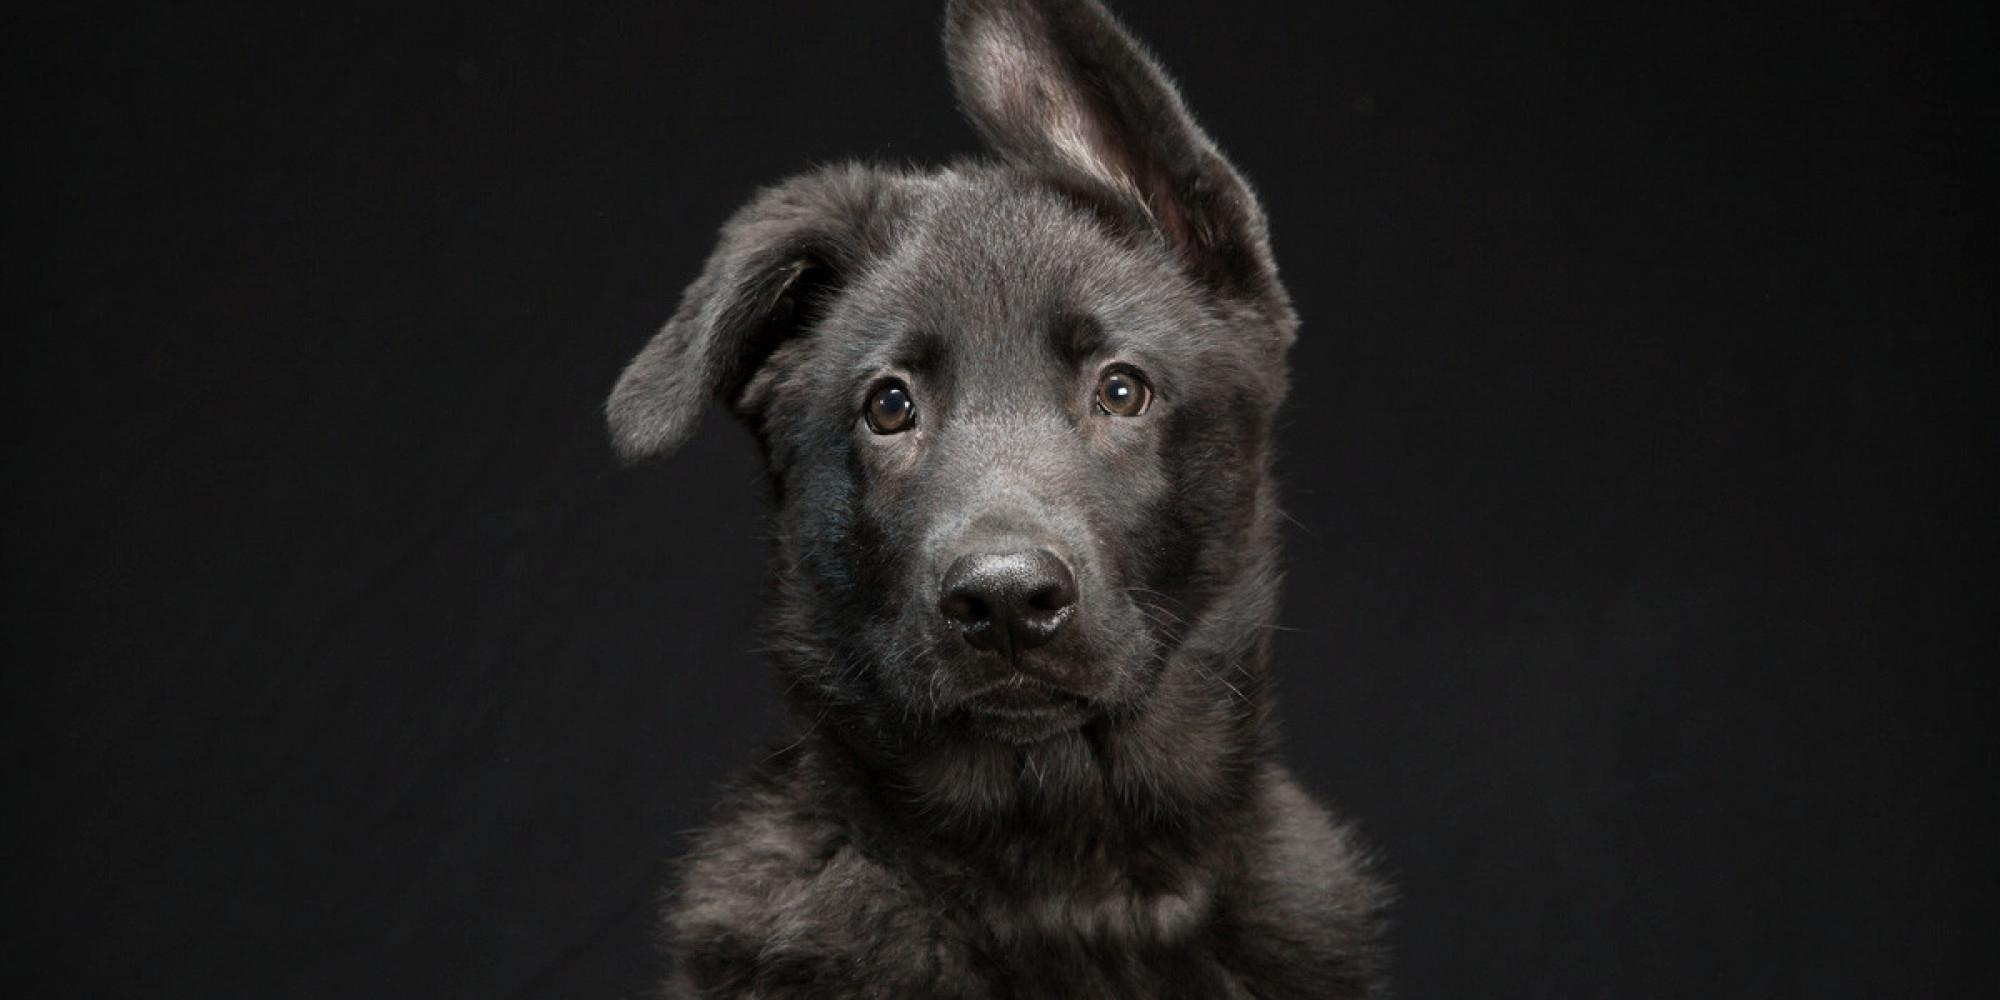

In [3]:
img_id = 1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
base_dream_path = './deepdream/data/target/'

# transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])

dream_set = dset.ImageFolder(base_dream_path,transform=transform)
# dset = datasets.ImageFolder(os.path.join(), transforms)
dset_loader = torch.utils.data.DataLoader(dream_set, batch_size=1)
# inputs, classes = next(iter(dset_loader))
# input_np = inputs.numpy()
inputs = dset_loader.dataset[img_id][0].unsqueeze(0)
input_np = inputs.numpy()

ddutil.showtensor(input_np)

# base_image = Image.fromarray(np.uint8(input_np * 255)).convert('RGBA')
# plt.imshow(base_image)

In [12]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1'

# load the model
model = ddresnet.resnet50(pretrained=True)
model.cuda()
# model = torch.nn.DataParallel(model, device_ids=[0, 1])
for param in model.parameters():
    param.require_grads = False

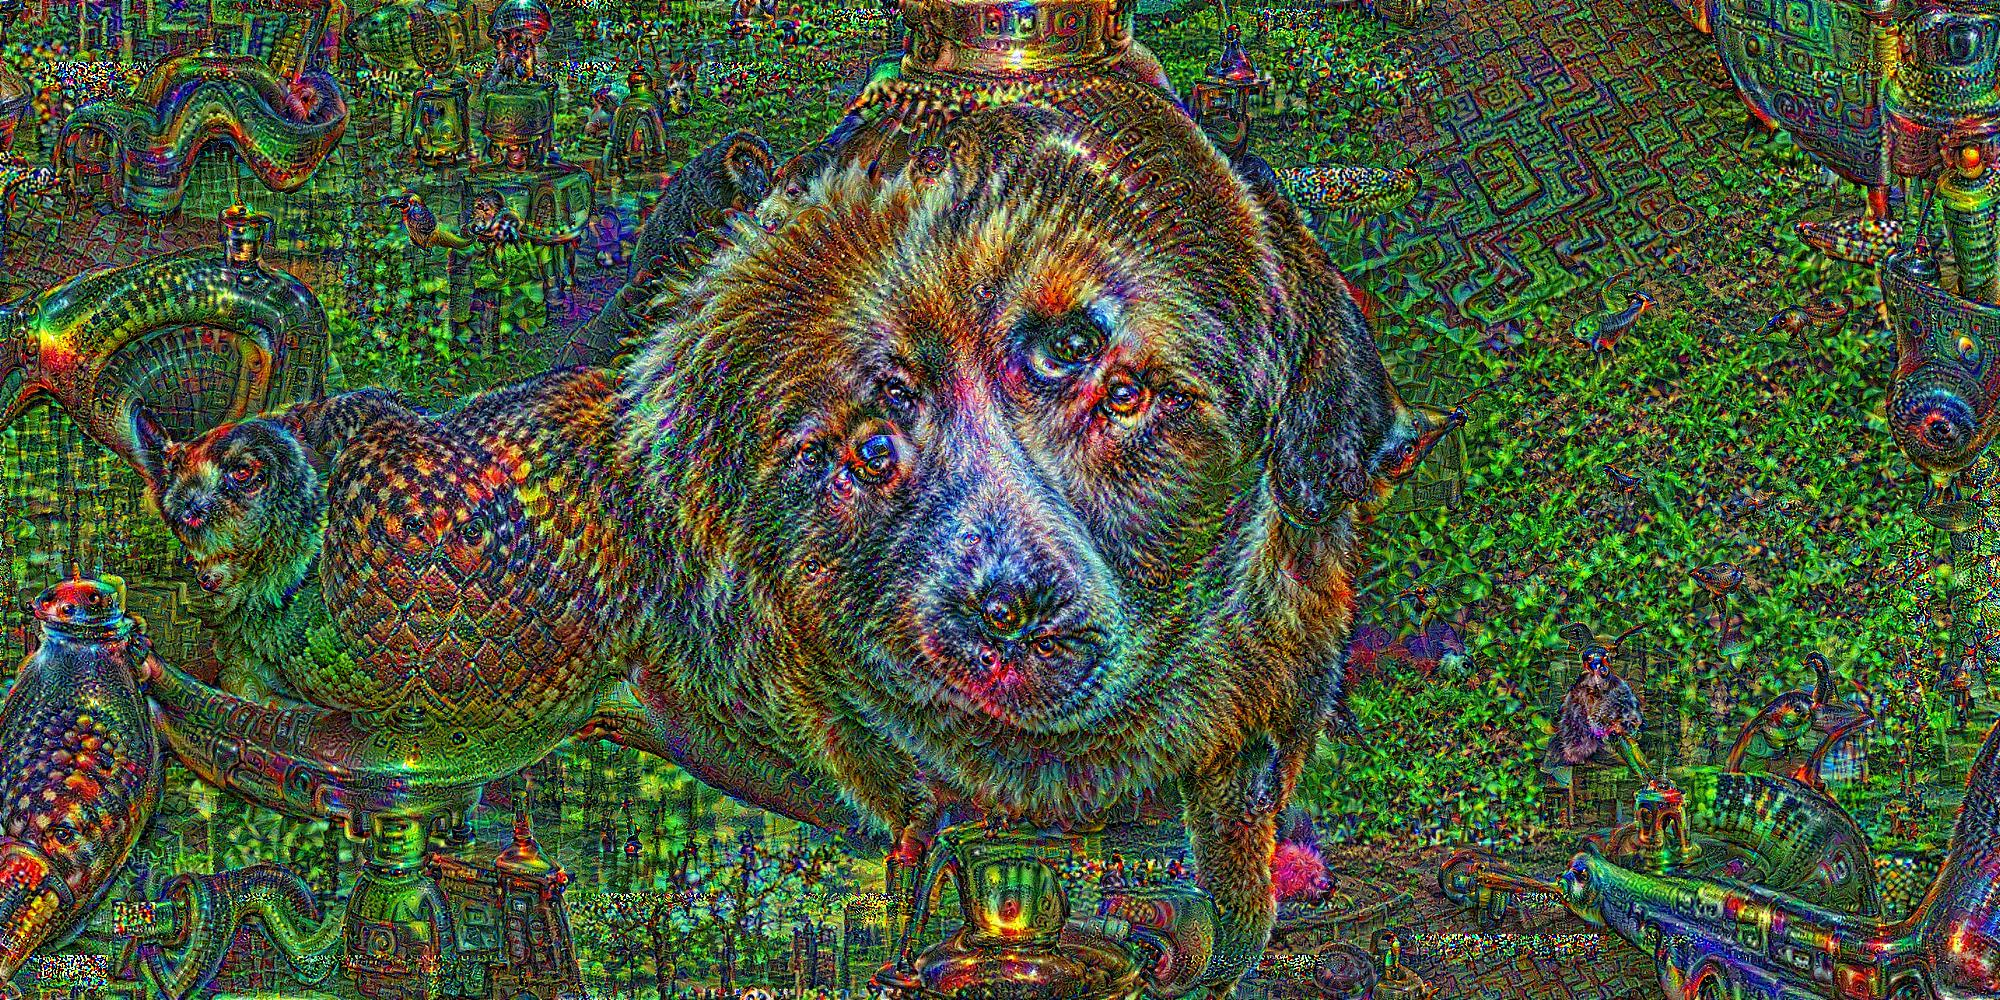

In [13]:
# deep dream
dream(model, input_np, 
          octave_n=10, 
          num_iterations=5, 
          lr=.18,
          max_jitter=120,
          show_every=5,
          end_layer=3)

In [ ]:
# To do:
# Update with model with more layers
# figure out how to activate specific neurons
# you need to draw to screen until cancel while being
# if you can do the above can you adjust which layer you're using at run

# Control the dream

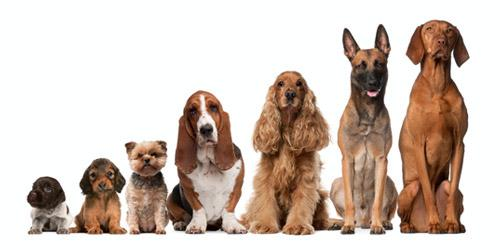

In [15]:
img_id = 3
base_dream_path = './deepdream/data/target/'

# transform = transforms.Compose([
#     transforms.Scale((425,425)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#     ])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])


# transform = transforms.Compose([transforms.Scale((224,224)),transforms.ToTensor()])

dream_set = dset.ImageFolder(base_dream_path,transform=transform)
# dset = datasets.ImageFolder(os.path.join(), transforms)
dset_loader = torch.utils.data.DataLoader(dream_set, batch_size=1)
#inputs_guide, classes_guide = next(iter(dset_loader))
#inputs_guide_np = inputs_guide.numpy()
inputs_guide = dset_loader.dataset[img_id][0].unsqueeze(0)
inputs_guide_np = inputs_guide.numpy()

ddutil.showtensor(inputs_guide_np)

# base_image = Image.fromarray(np.uint8(input_np * 255)).convert('RGBA')
# plt.imshow(base_image)

In [16]:
model = ddresnet.resnet50(pretrained=True)

In [17]:
print(model.fc)
total_classes = 2000
model.fc = nn.Linear(model.fc.in_features, total_classes) # Our dataset has 2 classes
print(model.fc)

Linear (2048 -> 1000)
Linear (2048 -> 2000)


In [238]:
#model = models.resnet18(pretrained=True)

In [19]:
model.cuda()
# model = torch.nn.DataParallel(model, device_ids=[0, 1]).cuda()
for param in model.parameters():
    param.require_grads = False

X_Variable = Variable(inputs_guide.cuda())
guide_features = model.forward(X_Variable, n_layer=3)

In [20]:
def objective_guide(dst, guide_features):
#     print(1)
    x = dst.data[0].cpu().numpy().copy()
#     print(type(dst), dst.size(), dst)
#     print(type(guide_features))
    y = guide_features.data[0].cpu().numpy()
#     print(dst.size())
    ch, w, h = x.shape
    x = x.reshape(ch,-1)      # (c，w*h)
    y = y.reshape(ch,-1)      # (c, w*h)
    A = x.T.dot(y) # compute the matrix of dot-products with guide features
    result = y[:,A.argmax(1)] # select ones that match best
    result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float)).cuda()
#     print(type(result), result.size(), result)
    return result

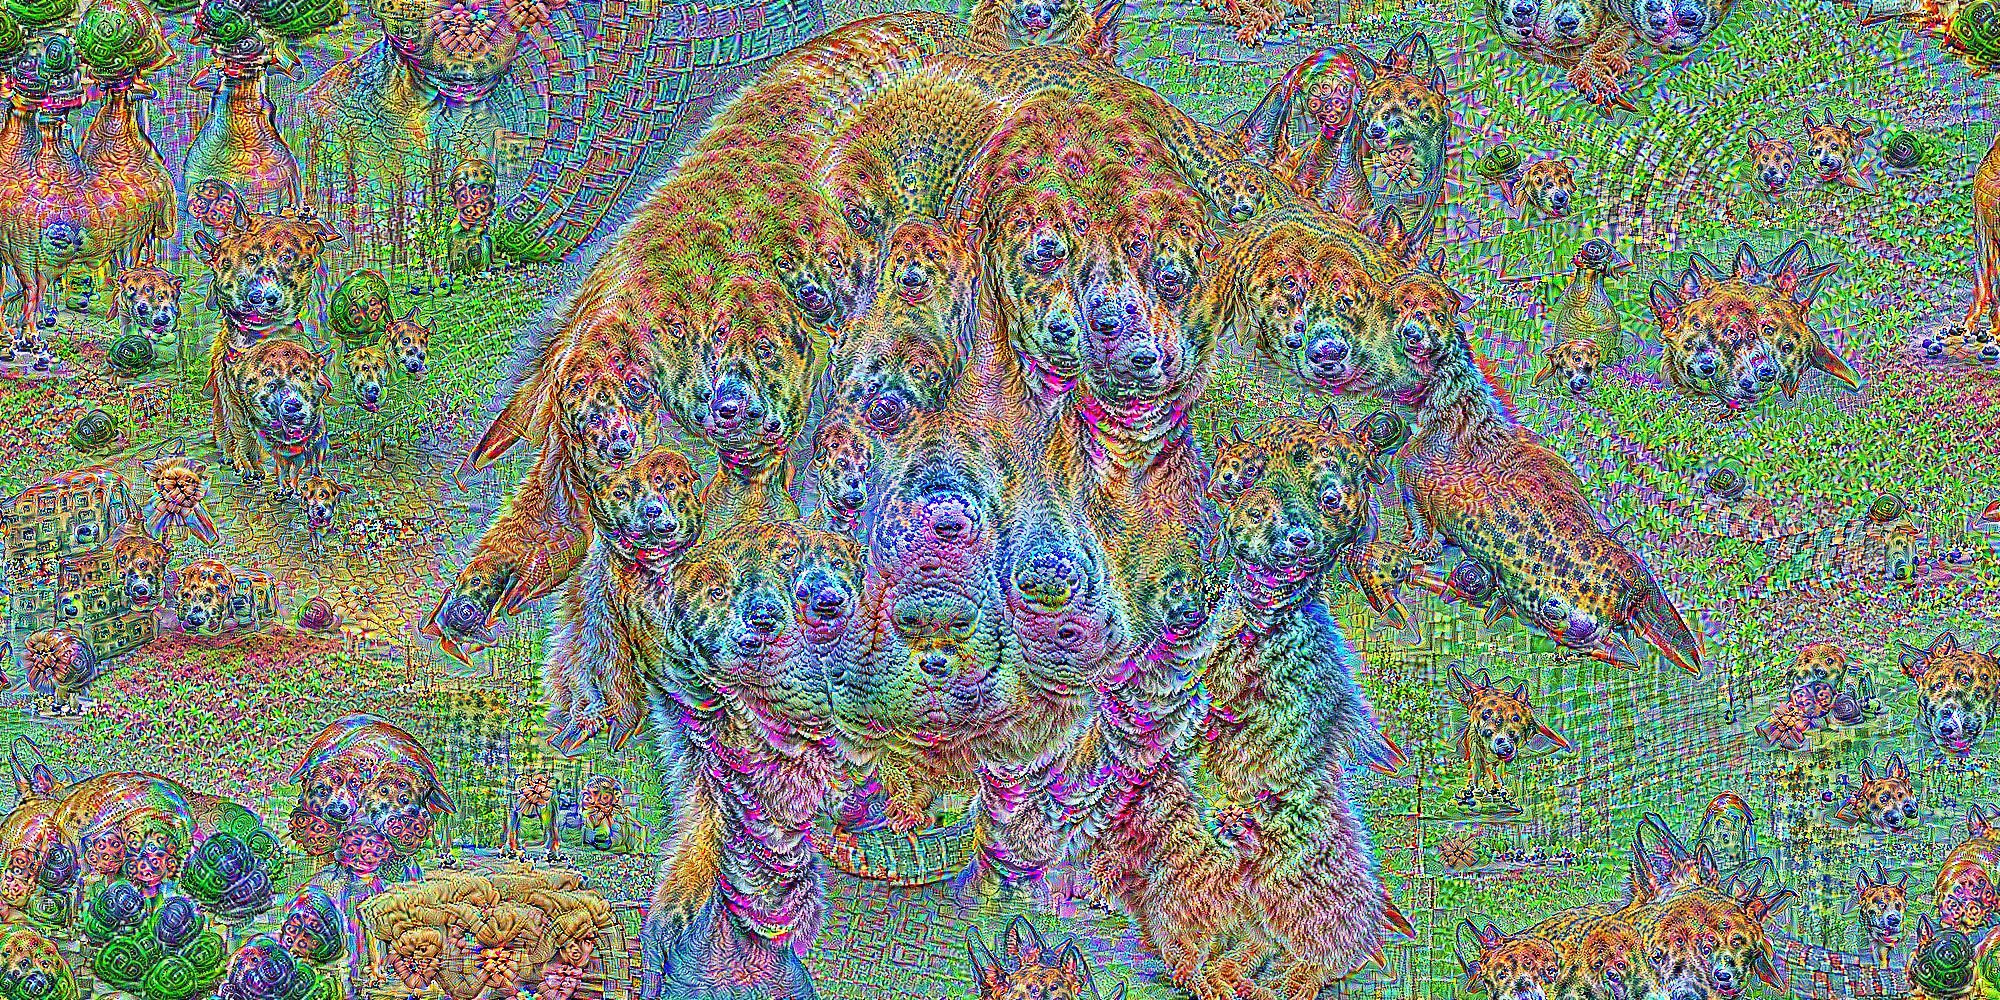

In [36]:
dream(model, input_np, 
      octave_n=5, 
      num_iterations=70, 
      lr=.16,
      max_jitter=100000,
      show_every=10,
      end_layer=3,
      octave_scale=1.4,
      objective=objective_guide,
      guide_features=guide_features)

### CNN Layer Visualization

In [1]:
from skimage import io
import torchvision.models as models
import deepdream.generate_class_specific_samples as gen
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pretrained_model = models.alexnet(pretrained=True)

In [ ]:
pretrained_model

In [6]:
target_class = 235  # German Shephard
cig = gen.ClassSpecificImageGeneration(pretrained_model, target_class)
gen_img = cig.generate()

Iteration: 25 Loss -28.48
Iteration: 50 Loss -117.72
Iteration: 75 Loss -376.11
Iteration: 100 Loss -588.98
Iteration: 125 Loss -697.32
Iteration: 150 Loss -779.57
Iteration: 175 Loss -827.19


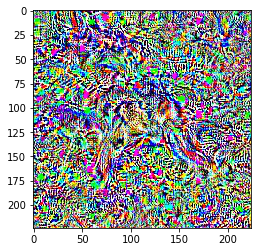

In [26]:
img = io.imread('./generated/iteration_199.jpg')
plt.imshow(img)